Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

In [6]:
# Set Seed
SEED = 123
numpy.random.seed(SEED)

rand_perm = []
for i in range(1,6):
    size = signal['signal'+str(i)].shape[1]
    print(f'Mouse{i}: Number of measurements is {size}.')
    rand = numpy.random.permutation(signal['signal'+str(i)].shape[1])
    rand_perm.append(rand)

Mouse1: Number of measurements is 11.
Mouse2: Number of measurements is 12.
Mouse3: Number of measurements is 14.
Mouse4: Number of measurements is 15.
Mouse5: Number of measurements is 12.


In [7]:
# Random assignment of label data for each measurement
rand_perm

[array([ 0,  4,  5,  7,  8,  9,  3,  1,  6, 10,  2]),
 array([ 4,  7,  5,  2,  3, 10,  8,  6, 11,  9,  1,  0]),
 array([ 5, 10, 12,  8,  6,  9, 11,  2,  3,  7,  1,  4, 13,  0]),
 array([13, 10, 14,  8,  2, 11, 12,  5,  1,  6,  4,  3,  9,  7,  0]),
 array([ 7,  8,  1,  4,  9,  6,  2, 11,  0,  5, 10,  3])]

# Preprocess

In [8]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [9]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [11]:
def Get_Dataset(TEST):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        rand = rand_perm[i-1]
        print(rand)
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,rand[j]])
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)
    return testX, testY

# Evaluate

In [12]:
import itertools

In [13]:
Models = ['GRU']

In [14]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

TEST
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


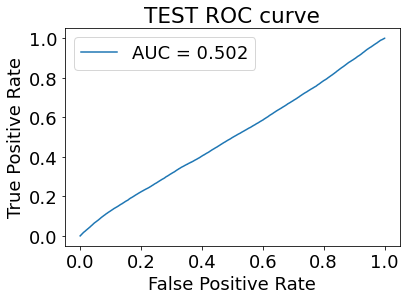

AUC: 0.502
Optimal threshold: 0.798
197670/197670 [==============================] - 43s 216us/sample - loss: 0.9331 - acc: 0.3789
TEST
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


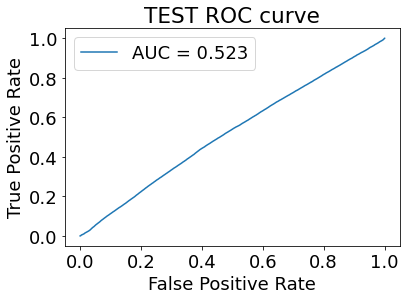

AUC: 0.523
Optimal threshold: 0.600
197670/197670 [==============================] - 42s 214us/sample - loss: 0.7676 - acc: 0.4046
TEST
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


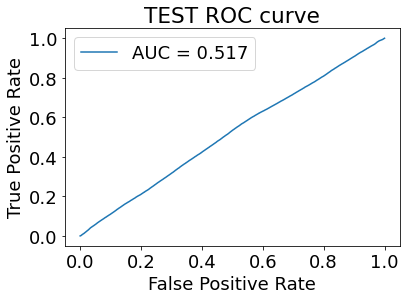

AUC: 0.517
Optimal threshold: 0.695
197670/197670 [==============================] - 43s 216us/sample - loss: 0.9080 - acc: 0.3711
TEST
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


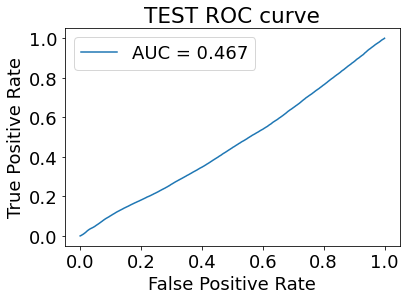

AUC: 0.467
Optimal threshold: 0.847
197670/197670 [==============================] - 42s 213us/sample - loss: 0.9669 - acc: 0.3677
TEST
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


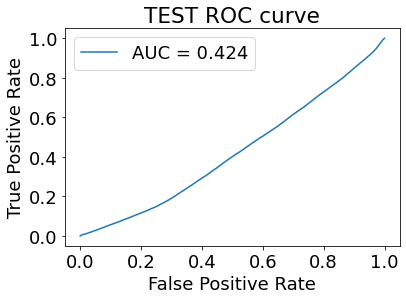

AUC: 0.424
Optimal threshold: 0.910
215640/215640 [==============================] - 47s 216us/sample - loss: 0.7207 - acc: 0.5127
TEST
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


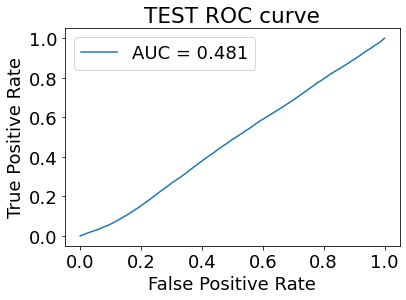

AUC: 0.481
Optimal threshold: 0.335
215640/215640 [==============================] - 48s 225us/sample - loss: 0.6680 - acc: 0.6204
TEST
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


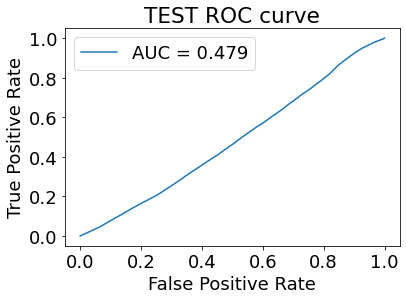

AUC: 0.479
Optimal threshold: 0.381
215640/215640 [==============================] - 47s 216us/sample - loss: 0.7088 - acc: 0.5744
TEST
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


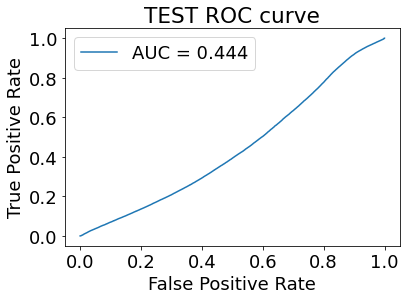

AUC: 0.444
Optimal threshold: 0.410
215640/215640 [==============================] - 46s 215us/sample - loss: 0.7031 - acc: 0.5682
TEST
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


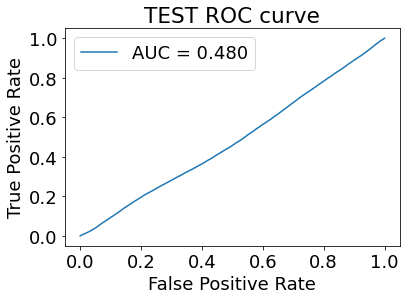

AUC: 0.480
Optimal threshold: 0.285
251580/251580 [==============================] - 56s 223us/sample - loss: 0.7125 - acc: 0.5443
TEST
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


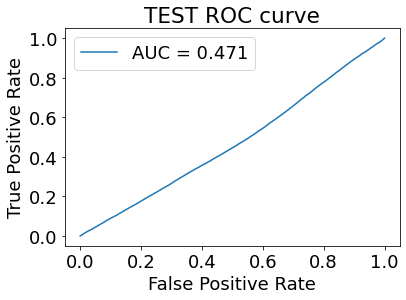

AUC: 0.471
Optimal threshold: 0.973
251580/251580 [==============================] - 58s 229us/sample - loss: 0.7584 - acc: 0.5073
TEST
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


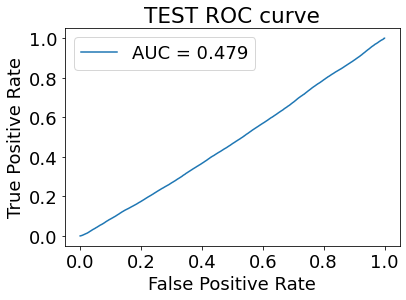

AUC: 0.479
Optimal threshold: 0.276
251580/251580 [==============================] - 57s 226us/sample - loss: 0.7452 - acc: 0.5490
TEST
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


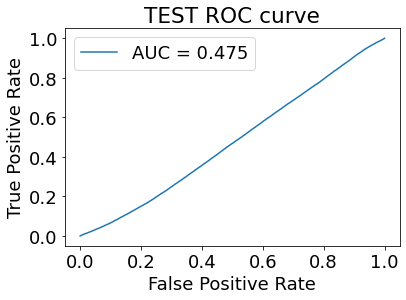

AUC: 0.475
Optimal threshold: 0.308
251580/251580 [==============================] - 56s 222us/sample - loss: 0.7425 - acc: 0.5149
TEST
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


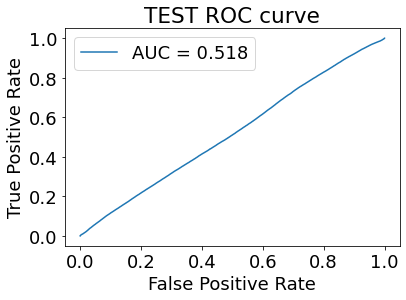

AUC: 0.518
Optimal threshold: 0.546
269550/269550 [==============================] - 60s 221us/sample - loss: 0.7248 - acc: 0.5673
TEST
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


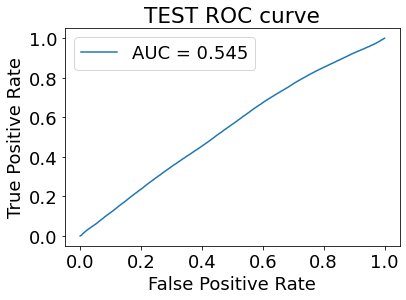

AUC: 0.545
Optimal threshold: 0.603
269550/269550 [==============================] - 60s 223us/sample - loss: 0.7188 - acc: 0.5805
TEST
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


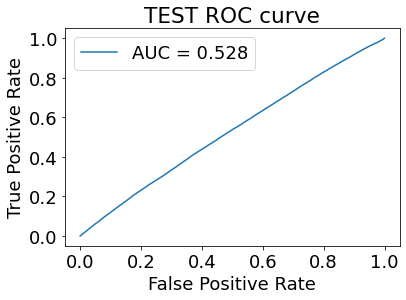

AUC: 0.528
Optimal threshold: 0.649
269550/269550 [==============================] - 61s 227us/sample - loss: 0.7167 - acc: 0.5608
TEST
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


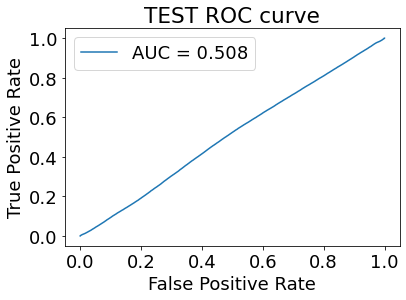

AUC: 0.508
Optimal threshold: 0.530
269550/269550 [==============================] - 63s 235us/sample - loss: 0.7344 - acc: 0.5296
TEST
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


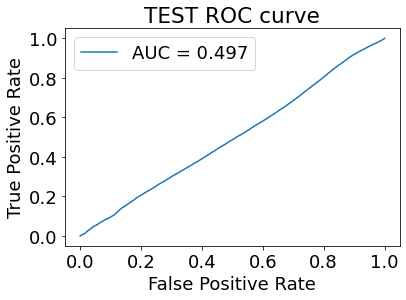

AUC: 0.497
Optimal threshold: 0.397
215640/215640 [==============================] - 47s 218us/sample - loss: 0.7039 - acc: 0.4783
TEST
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


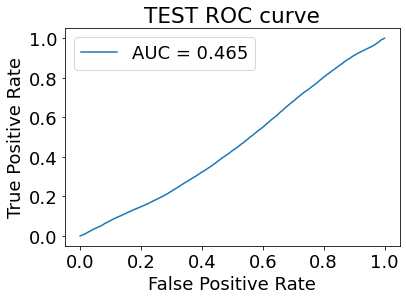

AUC: 0.465
Optimal threshold: 0.517
215640/215640 [==============================] - 50s 230us/sample - loss: 0.5860 - acc: 0.7507
TEST
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


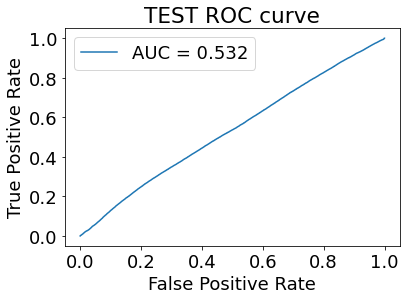

AUC: 0.532
Optimal threshold: 0.567
215640/215640 [==============================] - 50s 234us/sample - loss: 0.6517 - acc: 0.6477
TEST
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


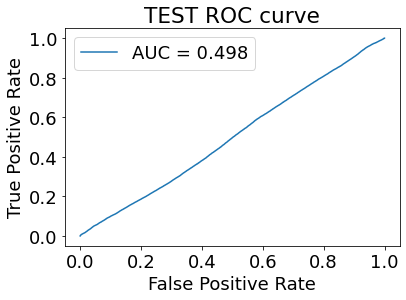

AUC: 0.498
Optimal threshold: 0.374
215640/215640 [==============================] - 49s 229us/sample - loss: 0.6955 - acc: 0.4838


In [15]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)
df_LOSS = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)
df_ACC = pandas.DataFrame(numpy.zeros([20, 3]), columns=['VALID','TEST']+Models)

l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    testX, testY = Get_Dataset(TEST)
    input_test = testX.transpose(0,2,1)
    for ModelType in Models:
        ver = f'{ModelType}_{VALID}_{TEST}_null'
        model_file_path = f'models_N20/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        df_AUC[ModelType][raw] = plot_roc(test_pred, testY, "TEST")
        results = model.evaluate(input_test,testY)
        df_LOSS[ModelType][raw] = results[0]
        df_ACC[ModelType][raw] = results[1]

In [16]:
df_AUC.to_csv('N20_null_model_result_AUC.csv')
df_AUC

,VALID,TEST,GRU
0,2.0,1.0,0.502382
1,3.0,1.0,0.522939
2,4.0,1.0,0.516643
3,5.0,1.0,0.467454
4,1.0,2.0,0.423736
5,3.0,2.0,0.480590
6,4.0,2.0,0.479171
7,5.0,2.0,0.443602
8,1.0,3.0,0.479875
9,2.0,3.0,0.470510


In [17]:
df_LOSS.to_csv('N20_null_model_result_BCEloss.csv')
df_LOSS

,VALID,TEST,GRU
0,2.0,1.0,0.933126
1,3.0,1.0,0.767618
2,4.0,1.0,0.907966
3,5.0,1.0,0.966941
4,1.0,2.0,0.720669
5,3.0,2.0,0.667959
6,4.0,2.0,0.708754
7,5.0,2.0,0.703106
8,1.0,3.0,0.712481
9,2.0,3.0,0.758419


In [18]:
df_ACC.to_csv('N20_null_model_result_Accuracy.csv')
df_ACC

,VALID,TEST,GRU
0,2.0,1.0,0.378879
1,3.0,1.0,0.404609
2,4.0,1.0,0.371063
3,5.0,1.0,0.367729
4,1.0,2.0,0.512697
5,3.0,2.0,0.620363
6,4.0,2.0,0.574392
7,5.0,2.0,0.568211
8,1.0,3.0,0.544308
9,2.0,3.0,0.507338
